# Notebook to train models

In [1]:
# Load packages
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import numpy as np
import random
import time as time
import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import warnings

from models import dummy_model1 as scRNASeq_model
from functions import data_preprocessing as dp

In [2]:
# Load data
file = '../../data/processed/immune_cells/bone_marrow_human/BM_1_adata.h5ad'#'../../data/processed/immune_cells/merged/Oetjen_merged.h5ad'
adata = sc.read(file, cache=True)

In [3]:
# Visualize data
visualize = False

if visualize:
    vis_adata = adata.copy()
    sc.pp.highly_variable_genes(vis_adata, n_top_genes=4000, flavor="cell_ranger")

    # Scale data using dp.scale_data() to subtract data by the mean of each feature and divide by the std of that feature.
    # This was done as a preprocessing step for annotating cell types in ScType in R and will therefore be used for visualization purpose. 
    # https://github.com/satijalab/seurat/issues/1166  
    vis_adata.X = dp.scale_data(vis_adata.X)

    sc.pp.pca(vis_adata, n_comps=40, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(vis_adata, n_neighbors=15, n_pcs=40)
    sc.tl.umap(vis_adata)
    sc.pl.umap(vis_adata, color='cell_type')

    # PatientID batch-effect
    sc.pl.umap(vis_adata, color='patientID')

    # Tissue batch-effect
    sc.pl.umap(vis_adata, color='tissue')

    # Visualize distribution of cell types
    cell_types = adata.obs["cell_type"]

    cell_type_counts = {}
    for string in cell_types:
        if string in cell_type_counts:
            cell_type_counts[string] += 1
        else:
            cell_type_counts[string] = 1

    sorted_data = sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=False)
    unique_strings, counts = zip(*sorted_data)

    bar_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in unique_strings]

    plt.barh(unique_strings, counts, color=bar_colors)

    plt.xlabel('Number of Cells')
    plt.ylabel('Cell Type')
    plt.title('Distribution of Cell Types')

    plt.tight_layout()
    plt.show()

In [4]:
# Store data on GPU and apply a random seed
data_env = scRNASeq_model.prep_data(adata=adata, HVG=True, Scaled=False, HVGs=4000)

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
data_env.X.shape[0]

2311

In [6]:
# Define model
model = scRNASeq_model.model(num_inputs=data_env.X.shape[1], num_hidden=2000, num_outputs=len(data_env.adata.obs["cell_type"].unique()), drop_out=0.5)

print(model)
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

model(
  (linear1): Linear(in_features=4000, out_features=2000, bias=True)
  (linear1_norm): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn1): Tanh()
  (linear2): Linear(in_features=2000, out_features=1000, bias=True)
  (act_fn2): Tanh()
  (linear3): Linear(in_features=1000, out_features=13, bias=True)
)
Parameter linear1.weight, shape torch.Size([2000, 4000])
Parameter linear1.bias, shape torch.Size([2000])
Parameter linear1_norm.weight, shape torch.Size([2000])
Parameter linear1_norm.bias, shape torch.Size([2000])
Parameter linear2.weight, shape torch.Size([1000, 2000])
Parameter linear2.bias, shape torch.Size([1000])
Parameter linear3.weight, shape torch.Size([13, 1000])
Parameter linear3.bias, shape torch.Size([13])
Number of parameters: 10020013


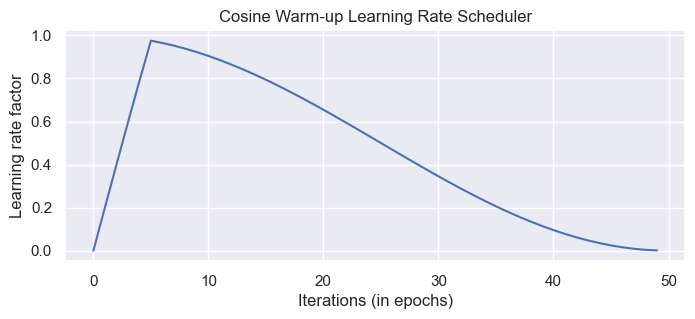

In [7]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    """
    From: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
    """

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=5, max_iters=50)

# Plotting
epochs = list(range(50))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in epochs)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [8]:
# Earlystopping
class EarlyStopping:
    def __init__(self, tolerance=10):

        self.tolerance = tolerance
        self.min_val = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss >= self.min_val:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.min_val = val_loss
            self.counter = 0

# Train model
def train_model(model, optimizer, lr_scheduler, loss_module, device, out_path, train_loader, val_loader, fold_idx, print_rate=10, num_epochs=10, earlystopping_threshold=10):

    print()
    print(f"Start Training CV fold {fold_idx+1}")
    print()

    # Add model to device
    model.to(device)

    # Initiate EarlyStopping
    early_stopping = EarlyStopping(earlystopping_threshold)

    # Training loop
    best_val_loss = np.inf  
    best_val_acc = 0.0
    best_preds = []
    train_start = time.time()
    for epoch in tqdm(range(num_epochs)):

        # Training
        model.train()
        train_loss = []
        for data_inputs, data_labels in train_loader:

            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            optimizer.zero_grad()
            preds = model(data_inputs)

            loss = loss_module(preds, data_labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Validation
        model.eval()
        val_loss = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_inputs, data_labels in val_loader:

                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                preds = model(data_inputs)

                loss = loss_module(preds, data_labels)
                val_loss.append(loss.item())

                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_labels.extend(data_labels.argmax(dim=1).cpu().numpy())

        # Metrics
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Check early stopping
        early_stopping(avg_val_loss)

        # Print epoch information
        if (epoch % print_rate == 0) or (epoch == (num_epochs-1)) or (early_stopping.early_stop):
            print(f"Epoch {epoch+1} | Training loss: {avg_train_loss:.4f} | Validation loss: {avg_val_loss:.4f} | Validation Accuracy: {accuracy:.4f} | Validation F1 Score: {f1:.4f}")

        # Update learning rate
        lr_scheduler.step()

        # Apply early stopping
        if early_stopping.early_stop:
            print(f"Stopped training using EarlyStopping at epoch {epoch+1}")
            break

        # Save model if performance have improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = accuracy
            best_preds = all_preds
            torch.save(model, f'{out_path}model_CV_{fold_idx+1}.pt')

    print()
    print(f"**Finished training CV fold {fold_idx+1}**")
    print()
    train_end = time.time()
    print(f"Training time: {(train_end - train_start)/60:.2f} minutes")

    return best_val_loss, best_val_acc, best_preds


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Ensure reproducibility
def rep_seed(seed):
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 42
rep_seed(seed)

# StratifiedKFold cross-validation
cv_losses = []
cv_accs = []
all_preds = []
all_preds_indices = []
folds = 5
batch_size = 256
total_train_start = time.time()
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
for fold_idx, (train_indices, val_indices) in enumerate(skf.split(data_env.X, data_env.labels)):

    train_data = data.Subset(data_env, train_indices)
    val_data = data.Subset(data_env, val_indices)

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = data.DataLoader(val_data, batch_size=batch_size)

    model = scRNASeq_model.model(num_inputs=data_env.X.shape[1], num_hidden=2000, num_outputs=len(data_env.adata.obs["cell_type"].unique()), drop_out=0.5)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")

    loss_module = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=5, max_iters=90)
    out_path = "trained_models/dummy_models1/"

    cv_loss, cv_acc, preds = train_model(model=model, 
                                optimizer=optimizer, 
                                lr_scheduler=lr_scheduler, 
                                loss_module=loss_module, 
                                device=device, 
                                out_path=out_path,
                                train_loader=train_loader, 
                                val_loader=val_loader,
                                fold_idx=fold_idx,
                                print_rate=10,
                                num_epochs=60, 
                                earlystopping_threshold=10)
    
    cv_losses.append(cv_loss)
    cv_accs.append(cv_acc)
    all_preds.extend(preds)
    all_preds_indices.extend(val_indices)

    del model, loss_module, optimizer, lr_scheduler

print()
print(f"CV loss score: {np.mean(cv_losses):.4f}")
print(f"CV accuracy score: {np.mean(cv_accs):.4f}")
print()

total_train_end = time.time()
print(f"Total training time: {(total_train_end - total_train_start)/60:.2f} minutes")

Number of parameters: 10020013

Start Training CV fold 1



  2%|▏         | 1/60 [00:16<16:39, 16.95s/it]

Epoch 1 | Training loss: 2.5688 | Validation loss: 2.5686 | Validation Accuracy: 0.0367 | Validation F1 Score: 0.0426


 18%|█▊        | 11/60 [00:23<00:39,  1.23it/s]

Epoch 11 | Training loss: 1.7025 | Validation loss: 1.7542 | Validation Accuracy: 0.9352 | Validation F1 Score: 0.9338


 28%|██▊       | 17/60 [00:28<01:11,  1.67s/it]


Epoch 18 | Training loss: 1.7023 | Validation loss: 1.7429 | Validation Accuracy: 0.9460 | Validation F1 Score: 0.9442
Stopped training using EarlyStopping at epoch 18

**Finished training CV fold 1**

Training time: 0.47 minutes
Number of parameters: 10020013

Start Training CV fold 2



  2%|▏         | 1/60 [00:00<00:44,  1.33it/s]

Epoch 1 | Training loss: 2.5617 | Validation loss: 2.5621 | Validation Accuracy: 0.1082 | Validation F1 Score: 0.1246


 18%|█▊        | 11/60 [00:07<00:31,  1.55it/s]

Epoch 11 | Training loss: 1.7077 | Validation loss: 1.7409 | Validation Accuracy: 0.9481 | Validation F1 Score: 0.9464


 35%|███▌      | 21/60 [00:13<00:24,  1.58it/s]

Epoch 21 | Training loss: 1.6999 | Validation loss: 1.7590 | Validation Accuracy: 0.9394 | Validation F1 Score: 0.9385


 42%|████▏     | 25/60 [00:16<00:23,  1.48it/s]


Epoch 26 | Training loss: 1.7021 | Validation loss: 1.7393 | Validation Accuracy: 0.9524 | Validation F1 Score: 0.9528
Stopped training using EarlyStopping at epoch 26

**Finished training CV fold 2**

Training time: 0.28 minutes
Number of parameters: 10020013

Start Training CV fold 3



  2%|▏         | 1/60 [00:00<00:41,  1.42it/s]

Epoch 1 | Training loss: 2.5639 | Validation loss: 2.5644 | Validation Accuracy: 0.0801 | Validation F1 Score: 0.0955


 18%|█▊        | 11/60 [00:07<00:31,  1.56it/s]

Epoch 11 | Training loss: 1.7052 | Validation loss: 1.7451 | Validation Accuracy: 0.9459 | Validation F1 Score: 0.9452


 22%|██▏       | 13/60 [00:08<00:31,  1.50it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize a one-hot encoded vector with all zeros
one_hot_encoded = np.zeros((len(all_preds),13))

# Set the corresponding positions to 1
for k, index in enumerate(all_preds):
    one_hot_encoded[k,index] = 1

# Convert to a tensor if needed
one_hot_encoded_tensor = torch.tensor(one_hot_encoded)

all_preds_decoded = data_env.onehot_encoder.inverse_transform(one_hot_encoded_tensor)

all_preds_ordered = []
for i in range(len(all_preds_indices)):
    for k, index in enumerate(all_preds_indices):
        if i == index:
            all_preds_ordered.append(all_preds_decoded[k][0])
            break

In [ ]:
# Inference and visulization

data_env.adata.obs["pred_cell_types"] = all_preds_ordered

data_env.adata.obs[["cell_type","pred_cell_types"]].head(10)

,cell_type,pred_cell_types
barcode,,
AAACCTGCAGCGAACA-1,Non-classical monocytes,Non-classical monocytes
AAACCTGCATGTCCTC-1,Memory CD4+ T cells,Memory CD4+ T cells
AAACCTGGTCGACTGC-1,Classical Monocytes,Classical Monocytes
AAACCTGGTCGCTTCT-1,Classical Monocytes,Classical Monocytes
AAACCTGTCCCGACTT-1,Memory CD4+ T cells,Memory CD4+ T cells
AAACGGGAGGGCACTA-1,Classical Monocytes,Classical Monocytes
AAACGGGCACCTCGGA-1,Progenitor cells,Progenitor cells
AAACGGGCACGGATAG-1,Progenitor cells,Progenitor cells
AAACGGGCACGTGAGA-1,CD4+ NKT-like cells,CD4+ NKT-like cells


c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


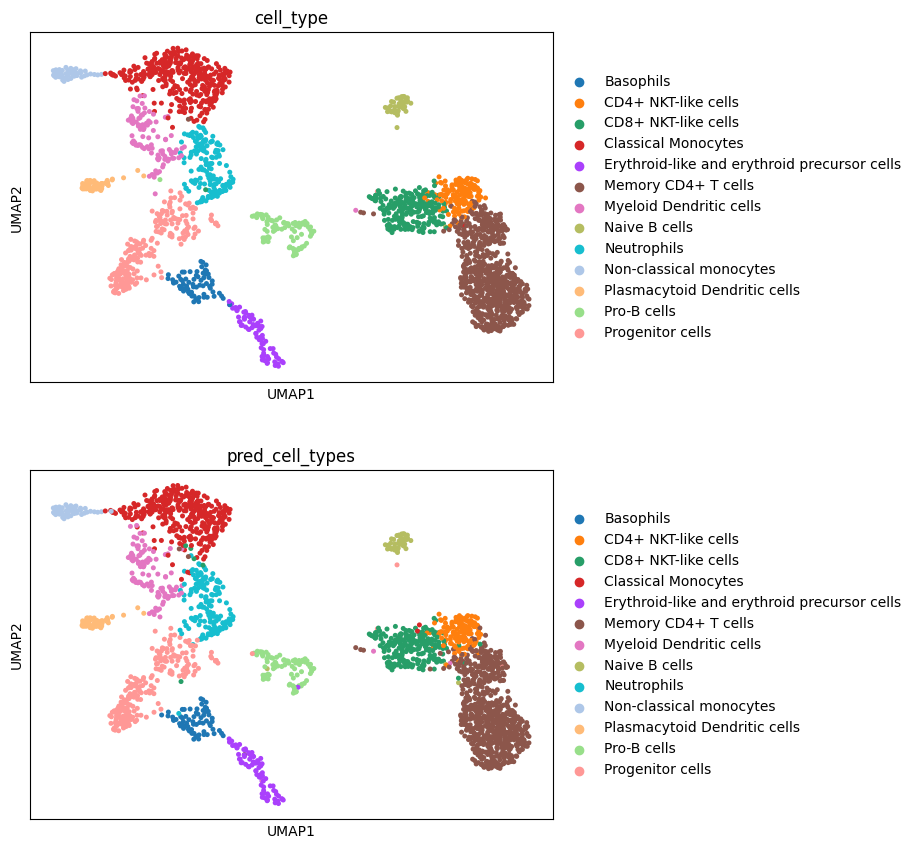

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

vis_adata = data_env.adata.copy()
sc.pp.highly_variable_genes(vis_adata, n_top_genes=4000, flavor="cell_ranger")

# Scale data using dp.scale_data() to subtract data by the mean of each feature and divide by the std of that feature.
# This was done as a preprocessing step for annotating cell types in ScType in R and will therefore be used for visualization purpose. 
# https://github.com/satijalab/seurat/issues/1166  
vis_adata.X = dp.scale_data(vis_adata.X)

sc.pp.pca(vis_adata, n_comps=40, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(vis_adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(vis_adata)
sc.pl.umap(vis_adata, color=['cell_type','pred_cell_types'], ncols=1)

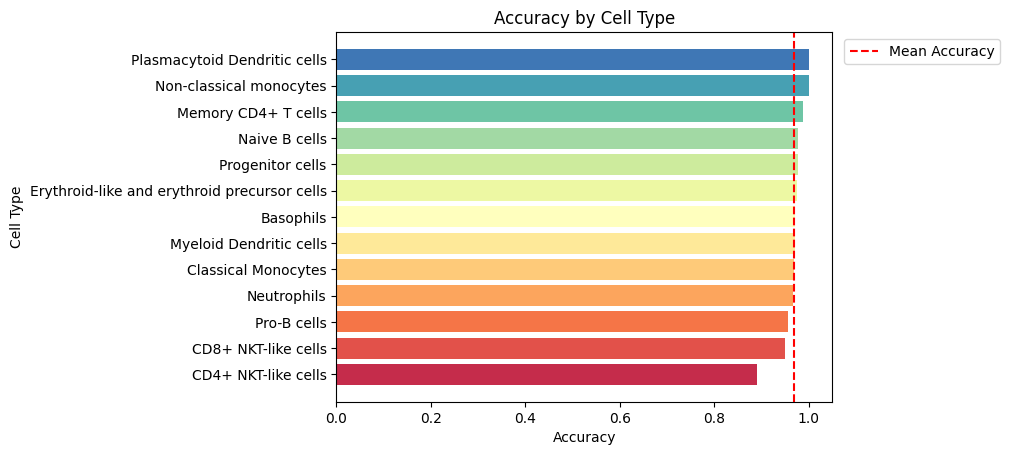

In [ ]:
# Calculate accuracy for each cell type
accuracy = (data_env.adata.obs['cell_type'] == data_env.adata.obs['pred_cell_types']).groupby(data_env.adata.obs['cell_type']).mean()

accuracy = accuracy.sort_values(ascending=True)

mean_accuracy = accuracy.mean()

colors = sns.color_palette("Spectral", len(accuracy))#np.random.rand(len(accuracy), 3)

plt.barh(accuracy.index, accuracy, color=colors)
plt.axvline(x=mean_accuracy, color='red', linestyle='--', label='Mean Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Cell Type')
plt.title('Accuracy by Cell Type')

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.show()